In [23]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
ERROR! Session/line number was not unique in database. History logging moved to new session 66


## Breast Cancer prediction using Deep Learning

### **Abstract**

Predicting IDC in Breast Cancer Histology Images
Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer.
The objective here is to identify IDC when it is present in otherwise unlabeled histopathology images using deep convulutional neural network. The dataset consists of approximately five thousand 50x50 pixel RGB digital images of H&E-stained breast histopathology samples that are labeled as either IDC or non-IDC. These numpy arrays are small patches that were extracted from digital images of breast tissue samples. The breast tissue contains many cells but only some of them are cancerous. Patches that are labeled "1" contain cells that have the characteristic of IDC.

### **Deep Learning model**

#### importing libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
import fnmatch
#import cv2
import argparse
import pickle
import os
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report
import keras
from keras import backend as K
#K.tensorflow_backend._get_available_gpus()
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
import random
import sys

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Loading the data

In [0]:

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a,allow_pickle=True)

sys.setrecursionlimit(10**6)

In [0]:
X = np.load("/content/drive/My Drive/data/X.npy") # images
Y = np.load("/content/drive/My Drive/data/Y.npy") # labels associated to images (0 = no IDC, 1 = IDC)

Describing the data

In [5]:
    print('Total number of images: {}'.format(len(X)))
    print('Number of IDC(-) Images: {}'.format(np.sum(Y==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(Y==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(Y)))
    print('Image shape : {}'.format(X[0].shape))

Total number of images: 5547
Number of IDC(-) Images: 2759
Number of IDC(+) Images: 2788
Percentage of positive images: 50.26%
Image shape : (50, 50, 3)


IDC vs Non-IDC image 

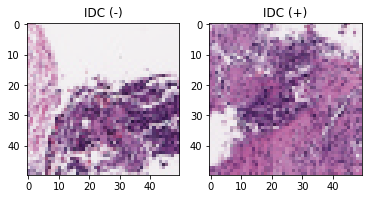

In [6]:
a = X[Y==0] # (0 = no IDC, 1 = IDC)
b = X[Y==1] 

# Plotting one array
plt.subplot(1,2,1)
plt.title('IDC (-)')
plt.imshow(a[100])
plt.subplot(1,2,2)
plt.title('IDC (+)')
plt.imshow(b[100])


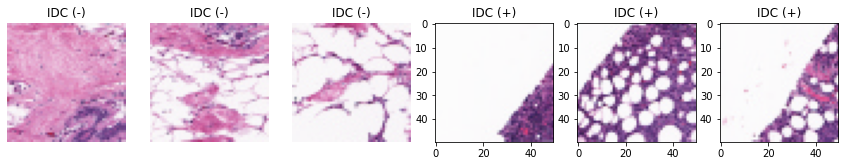

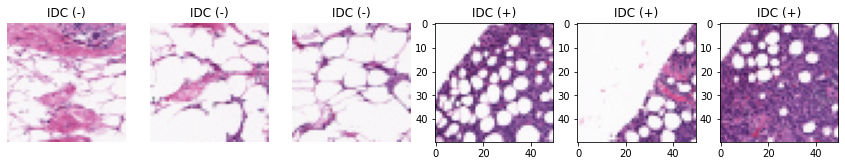

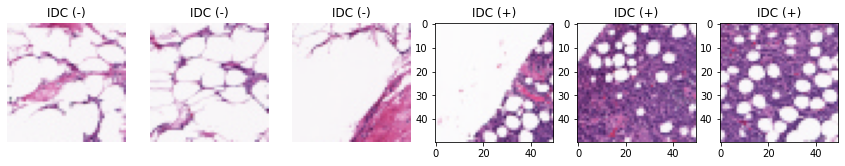

In [7]:
# Lets plot 3 instances(numpy arrays) of IDC + and IDC -ve images

for row in range(3):
    plt.figure(figsize=(20, 10))
    for col in range(3):
        plt.subplot(1,8,col+1)
        plt.title('IDC (-)')
        plt.imshow(a[row+col])
        plt.axis('off')       
        plt.subplot(1,8,col+4)
        plt.title('IDC (+)')
        plt.imshow(b[row+col])


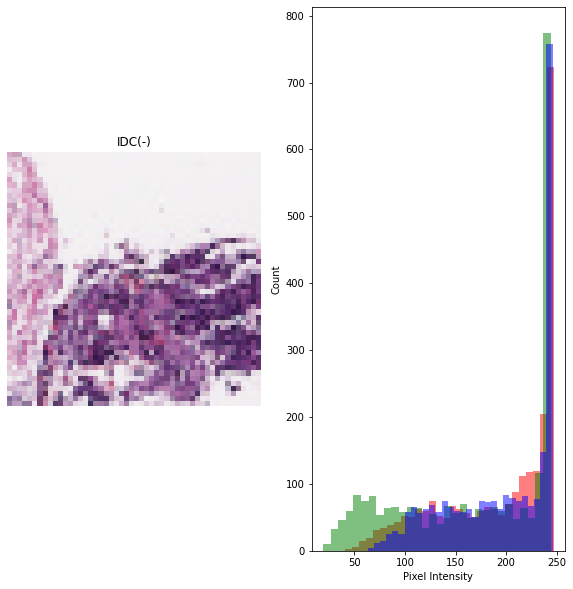

In [8]:
# Lets plot a histogram to see the RGB pixel intensities
def plotHistogram(a):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X[100])

Train - test split

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:30000] 
Y_train = Y_train[0:30000]
X_test = X_test[0:30000] 
Y_test = Y_test[0:30000]

# Normalize the data
X_train = X_train / 256.0
X_test = X_test / 256.0

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (4437, 50, 50, 3)
Testing Data Shape: (1110, 50, 50, 3)


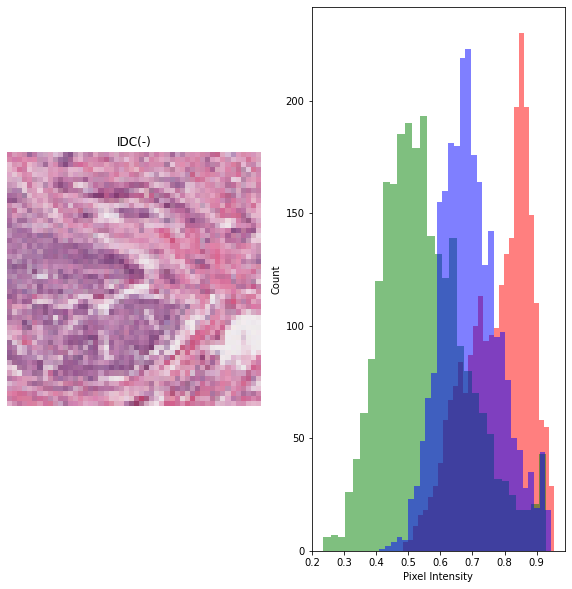

In [10]:
plotHistogram(X_train[100])

In [0]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]

X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

In [0]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

In [0]:
# Look at confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
# Special callback to see learning curves
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] 
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c = 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

In [0]:
import itertools

#### **Creating the Deep learning model using Keras**

#### considering this as a baseline model

Train on 4437 samples, validate on 1110 samples
Epoch 1/50
4437/4437 [==============================] - 2s 514us/step - loss: 2.1538 - accuracy: 0.4891 - val_loss: 0.7561 - val_accuracy: 0.5153
Epoch 2/50
4437/4437 [==============================] - 1s 146us/step - loss: 0.7497 - accuracy: 0.5091 - val_loss: 0.6929 - val_accuracy: 0.5153
Epoch 3/50
4437/4437 [==============================] - 1s 150us/step - loss: 0.7431 - accuracy: 0.4965 - val_loss: 0.6936 - val_accuracy: 0.4847
Epoch 4/50
4437/4437 [==============================] - 1s 146us/step - loss: 0.7348 - accuracy: 0.4961 - val_loss: 0.6938 - val_accuracy: 0.4847
Epoch 5/50
4437/4437 [==============================] - 1s 149us/step - loss: 0.7263 - accuracy: 0.5051 - val_loss: 0.6979 - val_accuracy: 0.4847
Epoch 6/50
4437/4437 [==============================] - 1s 147us/step - loss: 0.7185 - accuracy: 0.4994 - val_loss: 0.6954 - val_accuracy: 0.4847
Epoch 7/50
4437/4437 [==============================] - 1s 144us/step - loss

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


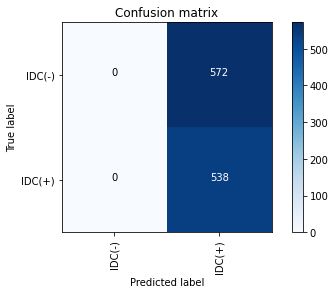

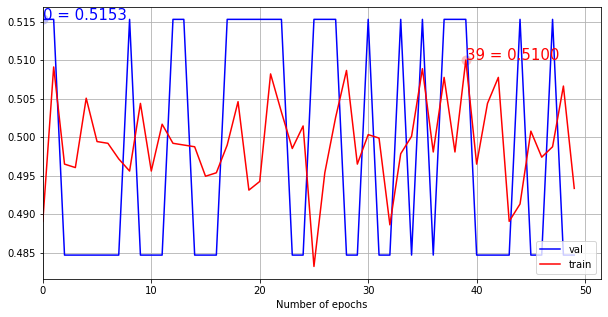

In [16]:
def runKerasCNN(a,b,c,d):
    
    batch_size = 128
    num_classes = 2
    epochs = 50  
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    # Creating neural network model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='sigmoid',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\n CNN model #1A - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
    
runKerasCNN(X_train, Y_train,  X_test, Y_test)
plotKerasLearningCurve()

The accuracy obtained is very less for sigmoid activation function and the accuracy of training data and validation are moving closely and hence may lead to overfitting.
The score is fluctuating 

##### Lets vary the parameters and try to see the impact on the model's accuracy

**Activation function** - changed to 'relu'

Train on 4437 samples, validate on 1110 samples
Epoch 1/50
4437/4437 [==============================] - 1s 193us/step - loss: 0.8443 - accuracy: 0.5580 - val_loss: 0.6654 - val_accuracy: 0.6333
Epoch 2/50
4437/4437 [==============================] - 1s 155us/step - loss: 0.6699 - accuracy: 0.6218 - val_loss: 0.6948 - val_accuracy: 0.4847
Epoch 3/50
4437/4437 [==============================] - 1s 152us/step - loss: 0.6580 - accuracy: 0.6356 - val_loss: 0.7777 - val_accuracy: 0.4847
Epoch 4/50
4437/4437 [==============================] - 1s 157us/step - loss: 0.6556 - accuracy: 0.6432 - val_loss: 0.6173 - val_accuracy: 0.6865
Epoch 5/50
4437/4437 [==============================] - 1s 153us/step - loss: 0.6236 - accuracy: 0.6581 - val_loss: 0.6080 - val_accuracy: 0.6856
Epoch 6/50
4437/4437 [==============================] - 1s 151us/step - loss: 0.6171 - accuracy: 0.6793 - val_loss: 0.6014 - val_accuracy: 0.6550
Epoch 7/50
4437/4437 [==============================] - 1s 156us/step - loss

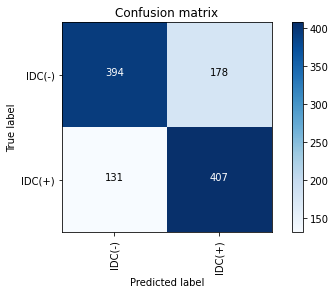

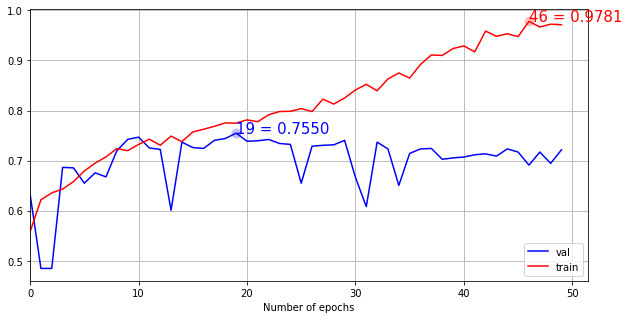

In [17]:
def runKerasCNN_AF(a,b,c,d):
    
    batch_size = 128
    num_classes = 2
    epochs = 50  
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    #lrelu = f.keras.layers.LeakyReLU(alpha=0.1)
    # Creating neural network model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\n CNN model after changing AF - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
    
runKerasCNN_AF(X_train, Y_train,  X_test, Y_test)
plotKerasLearningCurve()

Accuracy has improved significantly to 72% by changing the activation function
The network plateau for validation score has starting to reach a plateau after 40 epochs, but the training score is increasing continuously

**Cost function** - changed to 'hinge'

Train on 4437 samples, validate on 1110 samples
Epoch 1/50
4437/4437 [==============================] - 1s 198us/step - loss: 0.9968 - accuracy: 0.5001 - val_loss: 1.0306 - val_accuracy: 0.4847
Epoch 2/50
4437/4437 [==============================] - 1s 151us/step - loss: 0.9860 - accuracy: 0.5071 - val_loss: 1.0306 - val_accuracy: 0.4847
Epoch 3/50
4437/4437 [==============================] - 1s 152us/step - loss: 0.9858 - accuracy: 0.5071 - val_loss: 1.0306 - val_accuracy: 0.4847
Epoch 4/50
4437/4437 [==============================] - 1s 153us/step - loss: 0.9858 - accuracy: 0.5071 - val_loss: 1.0306 - val_accuracy: 0.4847
Epoch 5/50
4437/4437 [==============================] - 1s 153us/step - loss: 0.9858 - accuracy: 0.5071 - val_loss: 1.0306 - val_accuracy: 0.4847
Epoch 6/50
4437/4437 [==============================] - 1s 158us/step - loss: 0.9858 - accuracy: 0.5071 - val_loss: 1.0306 - val_accuracy: 0.4847
Epoch 7/50
4437/4437 [==============================] - 1s 157us/step - loss

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


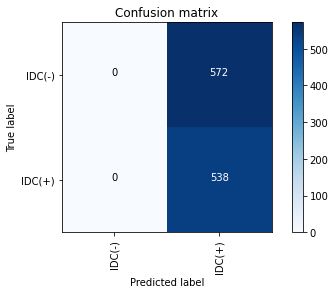

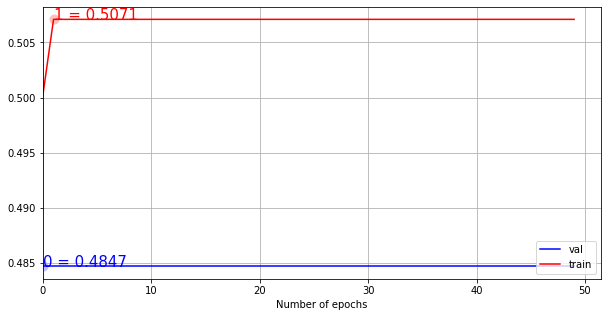

In [18]:
def runKerasCNN_CF(a,b,c,d):
    
    batch_size = 128
    num_classes = 2
    epochs = 50  
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    # Creating neural network model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_hinge,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\n CNN model cost function change - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
    
runKerasCNN_CF(X_train, Y_train,  X_test, Y_test)
plotKerasLearningCurve()

The accuracy score has reduced and has reached plateau in the beginning

**Epochs** - increased 

Train on 4437 samples, validate on 1110 samples
Epoch 1/65
4437/4437 [==============================] - 1s 195us/step - loss: 0.8777 - accuracy: 0.5344 - val_loss: 0.6641 - val_accuracy: 0.6252
Epoch 2/65
4437/4437 [==============================] - 1s 156us/step - loss: 0.6663 - accuracy: 0.6042 - val_loss: 0.6294 - val_accuracy: 0.6360
Epoch 3/65
4437/4437 [==============================] - 1s 156us/step - loss: 0.6709 - accuracy: 0.6209 - val_loss: 0.6057 - val_accuracy: 0.6847
Epoch 4/65
4437/4437 [==============================] - 1s 158us/step - loss: 0.6453 - accuracy: 0.6486 - val_loss: 0.7057 - val_accuracy: 0.5459
Epoch 5/65
4437/4437 [==============================] - 1s 160us/step - loss: 0.6206 - accuracy: 0.6788 - val_loss: 0.5925 - val_accuracy: 0.6802
Epoch 6/65
4437/4437 [==============================] - 1s 161us/step - loss: 0.6087 - accuracy: 0.6838 - val_loss: 0.5808 - val_accuracy: 0.7207
Epoch 7/65
4437/4437 [==============================] - 1s 159us/step - loss

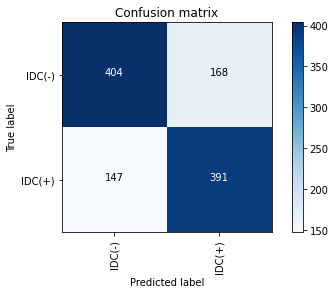

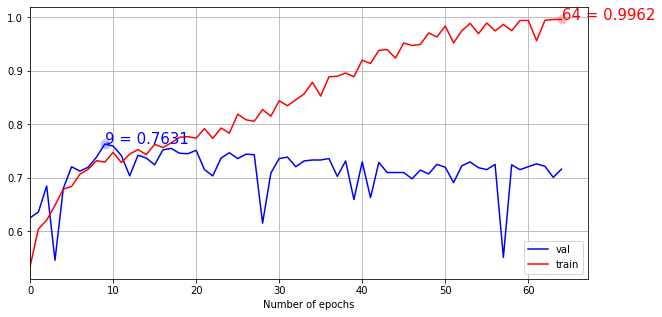

In [19]:
def runKerasCNN_epoch(a,b,c,d):
    
    batch_size = 128
    num_classes = 2
    epochs = 65  
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    #lrelu = f.keras.layers.LeakyReLU(alpha=0.1)
    # Creating neural network model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\n CNN model changing epochs - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
    
runKerasCNN_epoch(X_train, Y_train,  X_test, Y_test)
plotKerasLearningCurve()

The plateau is reaching at a later stage after 50 epochs by increasing the number of epochs

Optimizers - Changing the gradient descent optimizer

Train on 4437 samples, validate on 1110 samples
Epoch 1/50
4437/4437 [==============================] - 1s 185us/step - loss: 0.8735 - accuracy: 0.5454 - val_loss: 0.6633 - val_accuracy: 0.6577
Epoch 2/50
4437/4437 [==============================] - 1s 146us/step - loss: 0.5952 - accuracy: 0.7025 - val_loss: 0.5728 - val_accuracy: 0.7279
Epoch 3/50
4437/4437 [==============================] - 1s 149us/step - loss: 0.5598 - accuracy: 0.7217 - val_loss: 0.6078 - val_accuracy: 0.7054
Epoch 4/50
4437/4437 [==============================] - 1s 144us/step - loss: 0.5526 - accuracy: 0.7365 - val_loss: 0.5520 - val_accuracy: 0.7225
Epoch 5/50
4437/4437 [==============================] - 1s 144us/step - loss: 0.5170 - accuracy: 0.7546 - val_loss: 0.5594 - val_accuracy: 0.7108
Epoch 6/50
4437/4437 [==============================] - 1s 143us/step - loss: 0.5072 - accuracy: 0.7640 - val_loss: 0.5184 - val_accuracy: 0.7396
Epoch 7/50
4437/4437 [==============================] - 1s 143us/step - loss

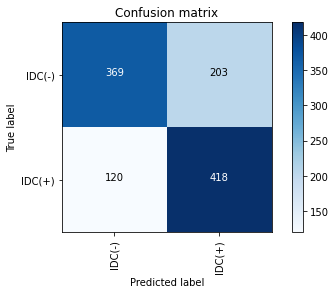

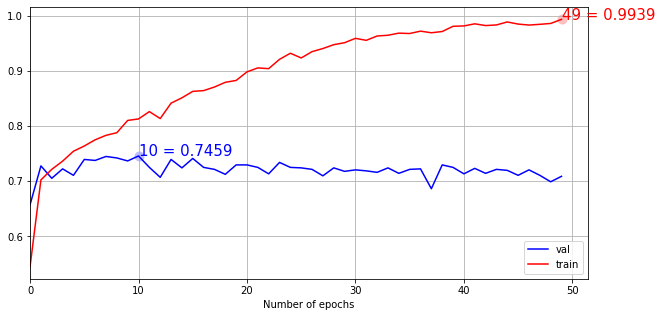

In [20]:
def runKerasCNN_Opt(a,b,c,d):
    
    batch_size = 128
    num_classes = 2
    epochs = 50  
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    #lrelu = f.keras.layers.LeakyReLU(alpha=0.1)
    # Creating neural network model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adamax(),
                  metrics=['accuracy'])
    model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\n CNN model changing optimizers- accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
    
runKerasCNN_Opt(X_train, Y_train,  X_test, Y_test)
plotKerasLearningCurve()

The accuracy has improved but the plateau is reaching around 30 epochs

Network architecture - changed the number of layers

Train on 4437 samples, validate on 1110 samples
Epoch 1/50
4437/4437 [==============================] - 2s 451us/step - loss: 1.8006 - accuracy: 0.6687 - val_loss: 1.1640 - val_accuracy: 0.4946
Epoch 2/50
4437/4437 [==============================] - 1s 219us/step - loss: 0.5995 - accuracy: 0.7275 - val_loss: 1.5411 - val_accuracy: 0.4946
Epoch 3/50
4437/4437 [==============================] - 1s 218us/step - loss: 0.5827 - accuracy: 0.7406 - val_loss: 0.5705 - val_accuracy: 0.7495
Epoch 4/50
4437/4437 [==============================] - 1s 218us/step - loss: 0.5565 - accuracy: 0.7528 - val_loss: 1.0505 - val_accuracy: 0.5135
Epoch 5/50
4437/4437 [==============================] - 1s 218us/step - loss: 0.5431 - accuracy: 0.7440 - val_loss: 0.9549 - val_accuracy: 0.5568
Epoch 6/50
4437/4437 [==============================] - 1s 220us/step - loss: 0.5157 - accuracy: 0.7762 - val_loss: 1.6270 - val_accuracy: 0.6000
Epoch 7/50
4437/4437 [==============================] - 1s 219us/step - loss

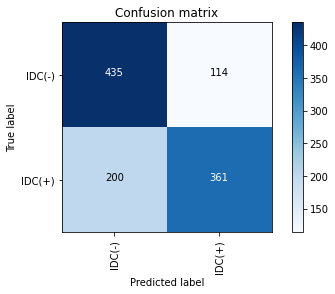

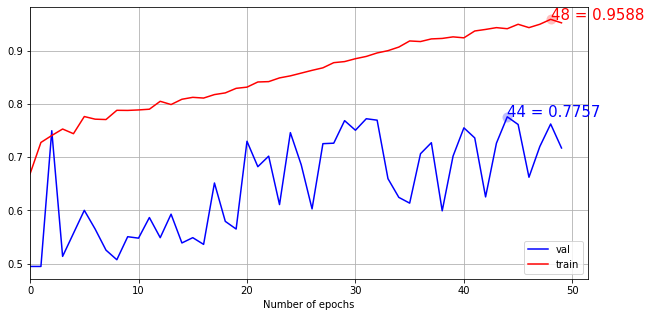

In [21]:
def runAnotherKeras(a, b,c,d):
    # my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out   
    batch_size = 128
    num_classes = 2
    epochs = 50
    # input image dimensions
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(1024, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    optimizer = RMSprop(lr=0.001, decay=1e-6)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    model.fit(a,b,
                  batch_size=batch_size,
                  verbose=1,
                  epochs=epochs,
                  validation_data=(c,d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\ CNN changing N/W architecture - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
runAnotherKeras(X_train, Y_train, X_test, Y_test)
plotKerasLearningCurve()

The accuracy has improved, but the network has not reached the constant till around after 40 epochs for the training score

Initializer - Changing the network initializer

Train on 4437 samples, validate on 1110 samples
Epoch 1/50
4437/4437 [==============================] - 1s 192us/step - loss: 0.7138 - accuracy: 0.5323 - val_loss: 0.6836 - val_accuracy: 0.5153
Epoch 2/50
4437/4437 [==============================] - 1s 152us/step - loss: 0.6859 - accuracy: 0.5763 - val_loss: 0.6491 - val_accuracy: 0.6883
Epoch 3/50
4437/4437 [==============================] - 1s 152us/step - loss: 0.6772 - accuracy: 0.5907 - val_loss: 0.6359 - val_accuracy: 0.6360
Epoch 4/50
4437/4437 [==============================] - 1s 156us/step - loss: 0.6404 - accuracy: 0.6540 - val_loss: 0.6228 - val_accuracy: 0.6414
Epoch 5/50
4437/4437 [==============================] - 1s 152us/step - loss: 0.6406 - accuracy: 0.6525 - val_loss: 0.6083 - val_accuracy: 0.7135
Epoch 6/50
4437/4437 [==============================] - 1s 151us/step - loss: 0.6349 - accuracy: 0.6464 - val_loss: 0.6398 - val_accuracy: 0.6532
Epoch 7/50
4437/4437 [==============================] - 1s 152us/step - loss

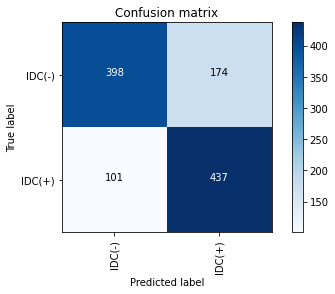

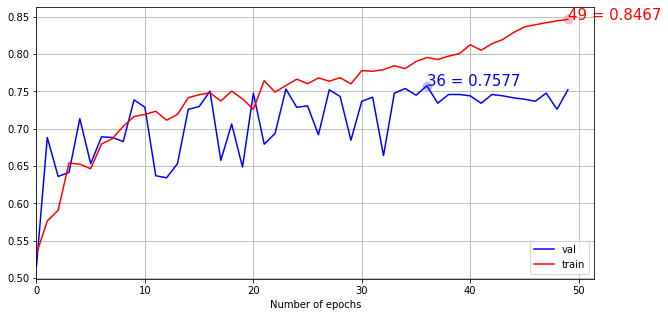

In [21]:
def runKerasCNN_Initializer(a,b,c,d):
    
    batch_size = 128
    num_classes = 2
    epochs = 50  
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    #lrelu = f.keras.layers.LeakyReLU(alpha=0.1)
    # Creating neural network model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,kernel_initializer='random_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\n CNN model after changing network initilaizer - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
    
runKerasCNN_Initializer(X_train, Y_train,  X_test, Y_test)
plotKerasLearningCurve()

The accuracy has increased significantly to 75% by changing the network initialization and the plateau is not reached around after 45 epochs

### **Conclusion**




*Here we have created a CNN model for training a network to detect if the inout image consist of IDC cancerous cells or not.
*We have tuned the parameters to see the impact on the accuracy of the neural network and the network plateau  
- Activation function 
- Cost function 
- Optimizer
- Epochs
- Network architecture 
- Network initializer



### License

Copyright 2020 Harika Reddy Gurram

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.